In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from geopy.distance import great_circle #calculate distances
from sklearn import metrics #evaluating models
from sklearn.model_selection import train_test_split, cross_val_score #set splitting and validation
from sklearn.linear_model import LinearRegression 
import xgboost as xgb #XGBoost classifier
import matplotlib.pyplot as plt #plotting
import seaborn as sns #plotting
from math import sin, cos, sqrt, atan2, radians
%matplotlib inline

In [2]:
train_file = "/Users/ssjhnson/Classwork/Fall 2018/Big Data Analytics /Project/data/train.csv"
test_file = "/Users/ssjhnson/Classwork/Fall 2018/Big Data Analytics /Project/data/test.csv"

In [3]:
test = pd.read_csv(test_file)

In [4]:
#Get types of values
test.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [7]:
#Set lighter types to a dictionary to speed up train dataset (float64 is an overkill for GPS coordinates)
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

In [ ]:
#Load chunks of the dataset in the defined types
#NOTE - you will likely need to adjust the chunksize based on the memory in your machine
train = pd.read_csv(train_file,chunksize=500000,dtype=types)
for chunk in train:

# Double check that everything read in okay by viewing the first few rows
# train.head()

# Get a summary of the data
#train.describe()

#Distribution plot of fares
#sns.distplot(train['fare_amount'])

    #Check how many rows have null values
    chunk.isnull().sum()

    #Drop nulls if exist
    chunk.dropna(inplace=True)

    #Now clean up the training dataset to eliminate out of range values

    #No negative fares please
    chunk = chunk[chunk['fare_amount'] > 0]
    #Trim rides with misplaced decimals or outside New York City
    chunk = chunk[(chunk['pickup_longitude'] < -71) & (chunk['pickup_longitude'] > -75)]
    chunk = chunk[(chunk['pickup_latitude'] > 40) & (chunk['pickup_latitude'] < 44)]
    chunk = chunk[(chunk['dropoff_longitude'] < -71) & (chunk['dropoff_longitude'] > -75)]
    chunk = chunk[(chunk['dropoff_latitude'] > 40) & (chunk['dropoff_latitude'] < 44)]
    #No negative passengers or clown cars
    chunk = chunk[(chunk['passenger_count'] > 0) & (chunk['passenger_count'] < 10)]

    #See new max and mins
    chunk.describe()

    chunk.to_csv("clean_data.csv", mode='a')

In [8]:
#Define function to calculate distance in km from coordinates
def dist_calc(df):
    for i,row in df.iterrows():
        df.at[i,'trip_distance'] = great_circle((row['pickup_latitude'],row['pickup_longitude']),(row['dropoff_latitude'],row['dropoff_longitude'])).km

In [9]:
cleaned_train_file = "/Users/ssjhnson/Classwork/Fall 2018/Big Data Analytics /Project/clean_data.csv"
#Load a small portion of the dataset for example training 
train = pd.read_csv(cleaned_train_file,nrows=20000,dtype=types)

In [10]:
#Get distance for both sets
dist_calc(train)
dist_calc(test)

In [11]:
#Get useable date for feature engineering
train['pickup_datetime'] = train['pickup_datetime'].str.replace(" UTC", "")
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

test['pickup_datetime'] = test['pickup_datetime'].str.replace(" UTC", "")
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

#Getting interger numbers from the pickup_datetime
train["hour"] = train.pickup_datetime.dt.hour
train["weekday"] = train.pickup_datetime.dt.weekday
train["month"] = train.pickup_datetime.dt.month
train["year"] = train.pickup_datetime.dt.year

test["hour"] = test.pickup_datetime.dt.hour
test["weekday"] = test.pickup_datetime.dt.weekday
test["month"] = test.pickup_datetime.dt.month
test["year"] = test.pickup_datetime.dt.year

In [12]:
#Function for distance calculation between coordinates as mapped variables
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [13]:
#Function for calculating distance between newly obtained distances from the hotspots.
def add_hotspot_dist(dataset):
    jfk_coord = (40.639722, -73.778889)
    lga_coord = (40.77725, -73.872611)
    manhattan_coord = (40.7831, -73.9712)
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    pickup_mhttn = sphere_dist(pickup_lat, pickup_lon, manhattan_coord[0], manhattan_coord[1]) 
    dropoff_mhttn = sphere_dist(manhattan_coord[0], manhattan_coord[1], dropoff_lat, dropoff_lon) 
    
    dataset['jfk_distance'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    dataset['lga_distance'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)
    dataset['mhttn_distance'] = pd.concat([pickup_mhttn, dropoff_mhttn], axis=1).min(axis=1)
    
    return dataset

In [14]:
#Run the functions to add the features to the dataset
train = add_hotspot_dist(train)
test = add_hotspot_dist(test)

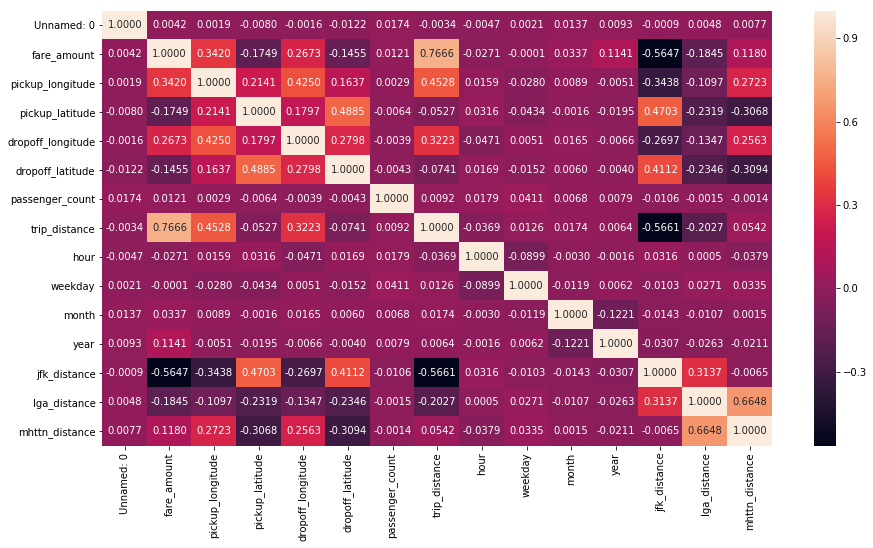

In [15]:
#Plot heatmap of value correlations
#The further away the value is from 0, the bigger the impact
plt.figure(figsize=(15,8))
sns.heatmap(train.drop(['key','pickup_datetime'],axis=1).corr(),annot=True,fmt='.4f')

In [16]:
# Train a basic Linear Regression model

X = train.drop(['key','fare_amount','pickup_datetime'],axis=1)
y = train['fare_amount']

In [17]:
#Split train set into test and train subsets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [18]:
#Drop columns from test dataset we're not going to use
test_pred = test.drop(['key','pickup_datetime'],axis=1)

In [ ]:
#Initialize a linear regression model, fit the data and get scores
lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))

In [ ]:
#Predict fares and get a rmse for them
y_pred = lm.predict(X)
lrmse = np.sqrt(metrics.mean_squared_error(y_pred, y))
print(lrmse)